In [3]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from matplotlib import rc
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from matplotlib.ticker import MaxNLocator
import scipy.signal
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import dill
import sys
sys.path.append('../')
from modelfitting import train_test_split, ROC_curve, PR_curve, stable_unstable_hist, calibration_plot, unstable_error_fraction

In [4]:
datapath = '/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/stability/MLstability/training_data/'
dset = 'random/'
featurefolder = 'ressummaryfeaturesxgbv6Norbits10000.0Nout1000/'
features = ['betanear', 'betafar']

In [5]:
trainingdatafolder = datapath+dset+featurefolder
trainX, trainY, testX, testY = train_test_split(trainingdatafolder, features)

In [6]:
space ={
        'max_depth': hp.randint('x_max_depth',  20),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
        'scale_pos_weight': hp.uniform("x_pos_weight", 1, 15),
        "learning_rate":hp.uniform("x_learning_rate",0.01,0.2),
        'colsample_bytree': hp.uniform ('x_tree_colsample', 0.5,1),
}

dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX, testY)
def objective(space):

    clf = XGBClassifier(n_estimators = 100, 
                            max_depth = space['max_depth'], 
                            min_child_weight =space['min_child_weight'],
                            subsample = space['subsample'],
                            colsample_bytree =space['colsample_bytree'],
                            learning_rate = space['learning_rate'], seed = 0)
    
    params = clf.get_xgb_params()
    #dtest
    score = xgb.cv(params, dtrain, nfold = 5, metrics = "auc", early_stopping_rounds=10)
    #print score
    #score = cross_val_score(clf, trainX, trainY, cv = 5, scoring="average_precision")
    avg_score =  np.mean(score["test-auc-mean"])
    error = np.mean(score["test-auc-std"])
    
    bst = xgb.train(params, dtrain)
    preds = bst.predict(dtest)
    test_score = metrics.roc_auc_score(testY, preds)
    
    print("SCORE:", avg_score, "ERROR", error, "HOLDOUT SCORE", test_score)

    return{'loss':1-test_score, 'status': STATUS_OK, "cv_score":avg_score , "cv_error":error, "holdout":test_score }

/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [7]:
%%time
trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 50, trials = trials)
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE:                                              
0.76744502                                          
ERROR                                               
0.028634939506478795                                
HOLDOUT SCORE                                       
0.8260282816516447                                  
SCORE:                                                                        
0.7634039400000001                                                            
ERROR                                                                         
0.023685349743515893                                                          
HOLDOUT SCORE                                                                 
0.8195182705743044                                                            
SCORE:                                                                        
0.77043206                                                                    
ERROR                                             

HOLDOUT SCORE                                                                 
0.8257751834396525                                                            
SCORE:                                                                        
0.78870538                                                                    
ERROR                                                                         
0.026838113863218604                                                          
HOLDOUT SCORE                                                                 
0.8425999729559408                                                            
SCORE:                                                                        
0.76100704                                                                    
ERROR                                                                         
0.02998467889591793                                                           
HOLDOUT SCORE                                       

0.8285937809722759                                                            
SCORE:                                                                        
0.79478568                                                                    
ERROR                                                                         
0.02426574574409673                                                           
HOLDOUT SCORE                                                                 
0.8443446834043813                                                            
SCORE:                                                                        
0.7848570400000001                                                            
ERROR                                                                         
0.02578796353338378                                                           
HOLDOUT SCORE                                                                 
0.8382689020631402                                  

In [8]:
best

{'x_learning_rate': 0.13250760484422328,
 'x_max_depth': 3,
 'x_min_child': 7.0,
 'x_pos_weight': 1.2132553037365474,
 'x_subsample': 0.9865542973546438,
 'x_tree_colsample': 0.6011322204557822}

In [9]:
best_xgbc = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])
params = best_xgbc.get_xgb_params()
score = xgb.cv(params, dtrain, nfold = 5, metrics = "auc", verbose_eval=True)
print(score)
d_Train = xgb.DMatrix(trainX, trainY)
d_Test = xgb.DMatrix(testX)
bst = xgb.train(params, d_Train)
preds = bst.predict(d_Test)
score = metrics.average_precision_score(testY, preds)
print(score)

[0]	train-auc:0.685044+0.00117564	test-auc:0.680786+0.00543282
[1]	train-auc:0.746955+0.0741807	test-auc:0.744245+0.0732839
[2]	train-auc:0.775082+0.0726775	test-auc:0.773129+0.0691777
[3]	train-auc:0.797803+0.0564877	test-auc:0.794435+0.0541408
[4]	train-auc:0.821984+0.0162639	test-auc:0.818143+0.0141905
[5]	train-auc:0.823598+0.0142747	test-auc:0.819792+0.0129385
[6]	train-auc:0.826391+0.00378253	test-auc:0.822169+0.00234257
[7]	train-auc:0.832443+0.00554544	test-auc:0.827865+0.00490454
[8]	train-auc:0.832246+0.00773849	test-auc:0.827385+0.00653285
[9]	train-auc:0.834119+0.00542426	test-auc:0.829517+0.00405649
   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.685044       0.001176       0.680786      0.005433
1        0.746955       0.074181       0.744245      0.073284
2        0.775082       0.072677       0.773129      0.069178
3        0.797803       0.056488       0.794435      0.054141
4        0.821984       0.016264       0.818143      0.014190
5       

/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [10]:
model = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])

model.fit(trainX, trainY)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=0.6011322204557822, gamma=0,
              learning_rate=0.13250760484422328, max_delta_step=0, max_depth=3,
              min_child_weight=7.0, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1.2132553037365474,
              seed=None, silent=True, subsample=0.9865542973546438)

Text(0.5, 1.0, 'ROC curve (AUC = 0.846)')

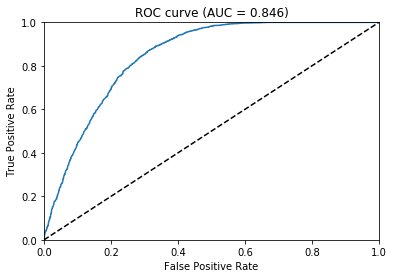

In [11]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(trainingdatafolder, model, features)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

In [12]:
pr_auc, precision, recall, PRthresholds = PR_curve(trainingdatafolder, model, features)
for i in range(0,len(recall), 15):
    print("Threshold {0}, recall = {1}, precision = {2}".format(PRthresholds[i], recall[i], precision[i]))

Threshold 0.025265149772167206, recall = 1.0, precision = 0.49459934689776436
Threshold 0.02770020253956318, recall = 0.9994921279837481, precision = 0.49696969696969695
Threshold 0.02941630221903324, recall = 0.9989842559674962, precision = 0.4988587370022825
Threshold 0.0334622785449028, recall = 0.9989842559674962, precision = 0.5010188487009679
Threshold 0.03686733916401863, recall = 0.9979685119349924, precision = 0.5028147389969294
Threshold 0.042767368257045746, recall = 0.9979685119349924, precision = 0.5054012345679012
Threshold 0.05077306926250458, recall = 0.9979685119349924, precision = 0.5074896694214877
Threshold 0.053700778633356094, recall = 0.9979685119349924, precision = 0.5098598858329009
Threshold 0.05815439671278, recall = 0.9974606399187405, precision = 0.5127937336814622
Threshold 0.06397344172000885, recall = 0.9974606399187405, precision = 0.5152151101783841
Threshold 0.07260555773973465, recall = 0.9974606399187405, precision = 0.5176594623089088
Threshold 0.0

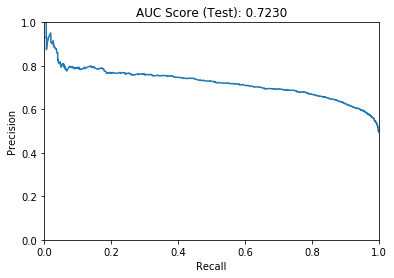

In [13]:
fig, ax = plt.subplots()
ax.plot(recall, precision)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title("AUC Score (Test): {0:.4f}".format(pr_auc))
plt.show()

(0, 210.6)

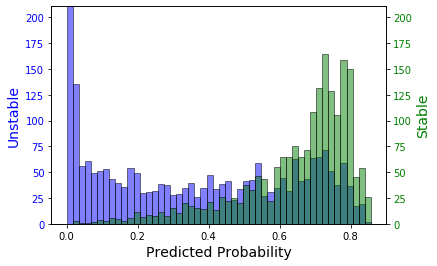

In [17]:
# Histogram:
bins = 50
Stable, Unstable = stable_unstable_hist(trainingdatafolder, model, features)

fig, ax1 = plt.subplots()
n, bins, pathces = ax1.hist(Unstable, bins, alpha=0.5, label='No', color='blue', edgecolor = "black")
ax1.set_xlabel('Predicted Probability', fontsize=14)
ax1.set_ylabel('Unstable',  fontsize=14, color='blue')
for tl in ax1.get_yticklabels():
    tl.set_color('blue')
    


ax2 = ax1.twinx()
n, bins , patches = ax2.hist(Stable, bins, alpha=0.5, label='Yes',color='green', edgecolor = "black")
#print(n.astype(int))
ax2.set_ylabel('Stable', fontsize=14, color='green')
for tl in ax2.get_yticklabels():
    tl.set_color('green')
    
    
#ax1.set_ylim(ax2.get_ylim())
ax1.set_ylim([0,8.1*n[-1]]) # goes up to ~4300
ax2.set_ylim([0,8.1*n[-1]]) # goes up to ~2100

Text(0, 0.5, 'Fraction actually stable')

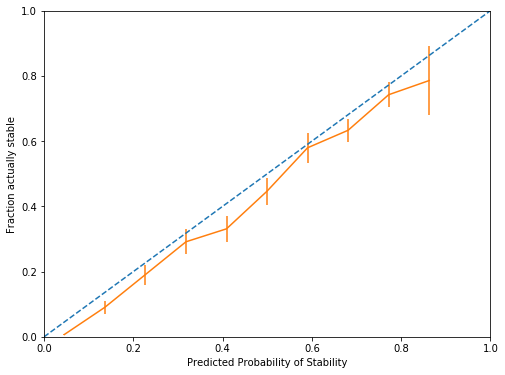

In [18]:
bincenters, fracstable, errorbars = calibration_plot(trainingdatafolder, model, features, bins=10)
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), '--')
ax.errorbar(bincenters, fracstable, errorbars)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xlabel('Predicted Probability of Stability')
ax.set_ylabel('Fraction actually stable')

../modelfitting.py:99: RuntimeWarning: divide by zero encountered in true_divide
  errorbars.append(np.sqrt(1./Nerrors + 1./hist[i])*errorfracs[-1]) # see calibration plot comment
../modelfitting.py:99: RuntimeWarning: invalid value encountered in double_scalars
  errorbars.append(np.sqrt(1./Nerrors + 1./hist[i])*errorfracs[-1]) # see calibration plot comment


Text(0.5, 1.0, 'Fraction of unstable systems mislabeled as stable')

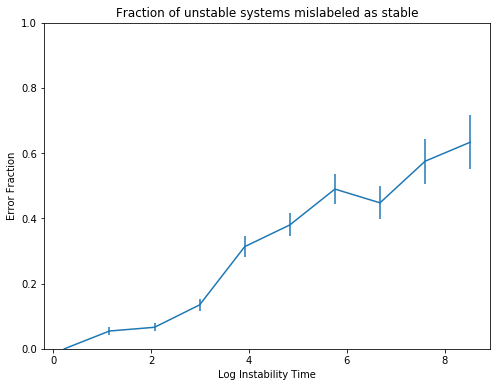

In [19]:
bincenters, errorfracs, errorbars = unstable_error_fraction(trainingdatafolder, model, features, bins=10)
fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(bincenters, errorfracs, errorbars)
ax.set_ylim([0,1])
ax.set_xlabel('Log Instability Time')
ax.set_ylabel('Error Fraction')
ax.set_title('Fraction of unstable systems mislabeled as stable')

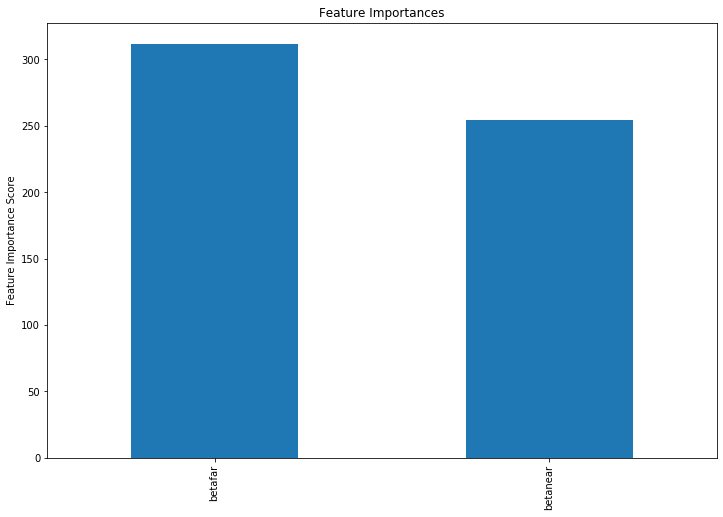

In [20]:
# feature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()

In [24]:
dill.dump([model, features, featurefolder], open(datapath+"../models/HillSpheresxgb_random.pkl", "wb"))